# Business Understanding

## Business Objective

## Executive Summary

# Data Engineering

## Import Libraries

In [763]:
# import libraries required to load, transform, analyze and plot data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='paper', style='darkgrid', 
        rc={'figure.facecolor':'white'}, font_scale=1.2)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import make_scorer, precision_recall_curve, classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [166]:
# remove scientific notation and restrictions on df rows/columns display
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('display.max_colwidth', 150)

## Data Dictionary

Data Source: IBM Cognos Telco Customer Churn Dataset

https://www.kaggle.com/yeanzc/telco-customer-churn-ibm-dataset

7043 observations with 33 variables

Column Definitions:

- CustomerID: A unique ID that identifies each customer.
- Count: A value used in reporting/dashboarding to sum up the number of customers in a filtered set.
- Country: The country of the customer’s primary residence.
- State: The state of the customer’s primary residence.
- City: The city of the customer’s primary residence.
- Zip Code: The zip code of the customer’s primary residence.
- Lat Long: The combined latitude and longitude of the customer’s primary residence.
- Latitude: The latitude of the customer’s primary residence.
- Longitude: The longitude of the customer’s primary residence.
- Gender: The customer’s gender: Male, Female
- Senior Citizen: Indicates if the customer is 65 or older: Yes, No
- Partner: Indicate if the customer has a partner: Yes, No
- Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.
- Tenure Months: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.
- Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No
- Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No
- Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.
- Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No
- Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No
- Device Protection: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No
- Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No
- Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.
- Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.
- Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.
- Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No
- Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check
- Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.
- Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.
- Churn Label: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.
- Churn Value: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.
- Churn Score: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.
- CLTV: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.
- Churn Reason: A customer’s specific reason for leaving the company. Directly related to Churn Category.

## Dataframe Basics

### Load File

In [277]:
# load primary source file to df
tc = pd.read_excel('data/Telco_customer_churn.xlsx', sheet_name='Telco_Churn')
tc.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964,-118.273,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059,-118.307,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048,-118.294,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650,820.500,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062,-118.316,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.800,"3,046.050",Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039,-118.266,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.700,"5,036.300",Yes,1,89,5340,Competitor had better devices


In [278]:
# drop columns not required or duplicative
drop_cols = ['Latitude', 'Longitude', 'Churn Label']
tc.drop(drop_cols, axis=1, inplace=True)

In [279]:
# convert column names to lower case without underscore
tc.columns = tc.columns.str.lower().str.replace(' ','_')

### Info

In [280]:
# review data types and null counts
tc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         7043 non-null   object 
 1   count              7043 non-null   int64  
 2   country            7043 non-null   object 
 3   state              7043 non-null   object 
 4   city               7043 non-null   object 
 5   zip_code           7043 non-null   int64  
 6   lat_long           7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   object 
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  tenure_months      7043 non-null   int64  
 12  phone_service      7043 non-null   object 
 13  multiple_lines     7043 non-null   object 
 14  internet_service   7043 non-null   object 
 15  online_security    7043 non-null   object 
 16  online_backup      7043 

**Notes on Info**
- Only non-null issue on Churn Reason (26.5% churned)
- Unexpected Data Types: Total Charges (s/b float)
- Will convert indicator columns from text to 0/1

In [281]:
# check for duplicate customers
dups = tc[tc.duplicated(subset=['customerid'])==True]
print(f'{dups.shape[0]} duplicate CustomerIDs found')

0 duplicate CustomerIDs found


### Data Cleaning

In [282]:
# check value counts by column
col_list = ['gender', 'senior_citizen', 'partner', 'dependents', 
            'phone_service', 'multiple_lines', 'internet_service', 
            'online_security', 'online_backup', 'device_protection', 
            'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 
            'paperless_billing', 'payment_method', 'churn_value', 
            'churn_reason', 'country', 'state', 'city', 'zip_code']

for col in col_list:
     print(f'\nValue Counts | column = {col}')
     print(tc[col].value_counts(normalize=True, dropna=False))


Value Counts | column = gender
Male     0.505
Female   0.495
Name: gender, dtype: float64

Value Counts | column = senior_citizen
No    0.838
Yes   0.162
Name: senior_citizen, dtype: float64

Value Counts | column = partner
No    0.517
Yes   0.483
Name: partner, dtype: float64

Value Counts | column = dependents
No    0.769
Yes   0.231
Name: dependents, dtype: float64

Value Counts | column = phone_service
Yes   0.903
No    0.097
Name: phone_service, dtype: float64

Value Counts | column = multiple_lines
No                 0.481
Yes                0.422
No phone service   0.097
Name: multiple_lines, dtype: float64

Value Counts | column = internet_service
Fiber optic   0.440
DSL           0.344
No            0.217
Name: internet_service, dtype: float64

Value Counts | column = online_security
No                    0.497
Yes                   0.287
No internet service   0.217
Name: online_security, dtype: float64

Value Counts | column = online_backup
No                    0.438
Yes   

**Notes on Value Counts**
- Change encoding to 0/1: Senior Citizen, Partner, Dependents, Phone Service, Multiple Lines, Internet Service, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies, Paperless Billing
- Create Group: Churn Reason (Customer Service, Product/Network, Pricing, Moved, Unknown)
- One-Hot Coding: Gender, Contract, Payment Method, Churn Reason Group
- All customers in California, USA 
- City distribution is wide, < 10% in major cities. Likely rural telecom co. Explore other geographic attributes.
- Data values look clean, no corrupt values or other NaNs to deal with.

## Data Preparation

### Functions

####  replace_yes_no

In [283]:
# replace yes-no variables with 0/1 for modeling
def replace_yes_no(X_df):
    """Transforms an X features dataframe in place using list of 
    categorical columns to replace class values yes/no to boolean 0/1's.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with replaced values
    """

    bool_list = ['senior_citizen', 'partner', 'dependents', 'phone_service', 
                 'multiple_lines', 'internet_service', 'online_security', 
                 'online_backup', 'device_protection', 'tech_support', 
                 'streaming_tv', 'streaming_movies', 'paperless_billing']
    for col in bool_list:
        X_df.replace({col : { 'Yes' : 1, 'No' : 0, 'No phone service' : 0, 
                                 'No internet service' : 0}}, inplace=True)
    return X_df

#### group_churn_reason

In [10]:
# create churn reason group to simplify
def group_churn_reason(X_df):
    """Creates new column by mapping churn reason to higher level parent on 
    an X features dataframe.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with new column
    """
    
    reason_map = {'Attitude of support person' : 'Cust Service',
                  'Attitude of service provider' : 'Cust Service', 
                  'Service dissatisfaction' : 'Cust Service', 
                  'Lack of self-service on Website' : 'Cust Service', 
                  'Poor expertise of phone support'  : 'Cust Service', 
                  'Poor expertise of online support' : 'Cust Service', 
                  'Competitor offered higher download speeds' : 'Product', 
                  'Competitor offered more data' : 'Product', 
                  'Competitor had better devices' : 'Product', 
                  'Network reliability' : 'Product', 
                  'Product dissatisfaction' : 'Product', 
                  'Limited range of services' : 'Product', 
                  'Competitor made better offer' : 'Pricing', 
                  'Price too high' : 'Pricing', 
                  'Extra data charges' : 'Pricing', 
                  'Long distance charges' : 'Pricing', 
                  'Lack of affordable download/upload speed' : 'Pricing', 
                  'Moved' : 'Moved', 
                  'Deceased' : 'Moved',
                  'Don\'t know' : 'Unknown'
                 }

    X_df['churn_rsn_grp'] = X_df.churn_reason.map(reason_map)
    return X_df

#### impute_total_charges

In [11]:
# take a look at total_charges
def impute_total_charges(X_df):
    """Imputes column total_charges in cases where column is non-numeric or 
    blank, using tenure_months and monthly_charge to estimate.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with imputed values
    """
    
    # impute total_charges as monthly x num months
    i=0
    for label, row in X_df.iterrows():
        if not isinstance(row['total_charges'], (int, float)): 
            i+=1
            X_df.loc[label, 'total_charges'] = row['tenure_months']*row['monthly_charges']

    X_df['total_charges'] = X_df['total_charges'].astype(float)
    print(f'Imputed {i} rows of non-numeric total_charges')
    return X_df

#### ohe_categories

In [374]:
# convert categorical columns to one-hot encoding features
def ohe_categories(X_df):
    """Creates one-hot encoded (OHE) features for a list of categorical columns 
    and simplies column names.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with OHE columns
    """
    
    # create list of multi-class variables for one-hot encoding
    categoricals = ['gender', 'internet_service', 'contract', 'payment_method', 
                    'churn_rsn_grp']

    # create one-hot encoded dummy variables for categoricals
    X_df_ohe = pd.get_dummies(X_df[categoricals], drop_first=False, dtype=int)
    X_df_ohe.rename(
        columns={'gender_Male' : 'gender_male',
                 'gender_Female' : 'gender_female', 
                 'internet_service_0' : 'internet_svc_none' , 
                 'internet_service_DSL' : 'internet_svc_dsl', 
                 'internet_service_Fiber optic' : 'internet_svc_fiber', 
                 'contract_Month-to-month' : 'contract_mtm', 
                 'contract_One year' : 'contract_1yr', 
                 'contract_Two year' : 'contract_2yr', 
                 'payment_method_Bank transfer (automatic)' : 'pmt_meth_bank_trx_auto', 
                 'payment_method_Credit card (automatic)' : 'pmt_meth_cc_auto', 
                 'payment_method_Electronic check' : 'pmt_meth_echeck', 
                 'payment_method_Mailed check' : 'pmt_meth_mail_check', 
                 'churn_rsn_grp_Cust Service' : 'churn_rsn_grp_cust_svc',                             
                 'churn_rsn_grp_Moved' : 'churn_rsn_grp_moved', 
                 'churn_rsn_grp_Pricing' : 'churn_rsn_grp_pricing', 
                 'churn_rsn_grp_Product' : 'churn_rsn_grp_product', 
                 'churn_rsn_grp_Unknown' : 'churn_rsn_grp_unknown'
                }, inplace = True)
    
    # concatenate OHE with original df, and drop original category columns
    X_df2 = pd.concat([X_df, X_df_ohe], axis=1)
    X_df2.drop(categoricals, axis=1, inplace=True)
    
    return X_df2

#### map_products

In [764]:
# create new columns combining customer services
def map_products(X_df):
    """Creates product columns that groups important combinations of services

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with new columns
    """    
    prod_cols = ['p1_phone_only', 'p2_phone_multi', 'p3_dsl_only', 'p4_dsl_plus', 
                 'p5_dsl_bund_core', 'p6_dsl_bund_plus', 'p7_fib_bund_core', 
                 'p8_fib_bund_plus']
    for newcol in prod_cols:
        X_df[newcol]= 0
        
        X_df.loc[(X_df['phone_service']==1) & (X_df['multiple_lines']==0) & 
         (X_df['internet_svc_dsl']==0) & (X_df['internet_svc_fiber']==0) & 
         (X_df['tech_support']==0) & (X_df['online_backup']==0) & 
         (X_df['online_security']==0) & (X_df['device_protection']==0), 
         'p1_phone_only'] = 1

        X_df.loc[(X_df['phone_service']==1) & (X_df['multiple_lines']==1) & 
         (X_df['internet_svc_dsl']==0) & (X_df['internet_svc_fiber']==0) & 
         (X_df['tech_support']==0) & (X_df['online_backup']==0) &
         (X_df['online_security']==0) & (X_df['device_protection']==0), 
         'p2_phone_multi'] = 1

        X_df.loc[(X_df['phone_service']==0) & (X_df['multiple_lines']==0) & 
         (X_df['internet_svc_dsl']==1) & (X_df['internet_svc_fiber']==0) & 
         (X_df['tech_support']==0) & (X_df['online_backup']==0) &
         (X_df['online_security']==0) & (X_df['device_protection']==0), 
         'p3_dsl_only'] = 1

        X_df.loc[(X_df['phone_service']==0) & (X_df['multiple_lines']==0) & 
         (X_df['internet_svc_dsl']==1) & (X_df['internet_svc_fiber']==0) & 
         ((X_df['tech_support']==1) | (X_df['online_backup']==1) |
         (X_df['online_security']==1) | (X_df['device_protection']==1)), 
         'p4_dsl_plus'] = 1

        X_df.loc[(X_df['phone_service']==1) & (X_df['multiple_lines']==0) & 
         (X_df['internet_svc_dsl']==1) & (X_df['internet_svc_fiber']==0) & 
         (X_df['tech_support']==0) & (X_df['online_backup']==0) &
         (X_df['online_security']==0) & (X_df['device_protection']==0), 
         'p5_dsl_bund_core'] = 1

        X_df.loc[(X_df['phone_service']==1) & (X_df['internet_svc_dsl']==1) 
         & (X_df['internet_svc_fiber']==0) & ((X_df['multiple_lines']==1) | 
         (X_df['tech_support']==1) | (X_df['online_backup']==1) |
         (X_df['online_security']==1) | (X_df['device_protection']==1)), 
         'p6_dsl_bund_plus'] = 1

        X_df.loc[(X_df['phone_service']==1) & (X_df['multiple_lines']==0) & 
         (X_df['internet_svc_dsl']==0) & (X_df['internet_svc_fiber']==1) & 
         (X_df['tech_support']==0) & (X_df['online_backup']==0) &
         (X_df['online_security']==0) & (X_df['device_protection']==0), 
         'p7_fib_bund_core'] = 1

        X_df.loc[(X_df['phone_service']==1) & (X_df['internet_svc_dsl']==0) & 
         (X_df['internet_svc_fiber']==1) & ((X_df['multiple_lines']==1) | 
         (X_df['tech_support']==1) | (X_df['online_backup']==1) |
         (X_df['online_security']==1) | (X_df['device_protection']==1)), 
         'p8_fib_bund_plus'] = 1

    return X_df

#### create_features

In [765]:
# function creates a few calculated metrics as features
def create_features(X_df):
    """Creates calculated fields services_cnt and monthly_charge_life_avg as 
    new features on dataframe.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with new columns
    """

    # create column for lifetime average monthly charge
    X_df['charge_trend_index'] = np.where(X_df.tenure_months!=0, 
                                               round(X_df.monthly_charges / 
                                               (X_df.total_charges / 
                                                X_df.tenure_months), 2), 
                                               X_df.monthly_charges)
    
    # create feature 0/1 whether customer streams content via internet svc
    X_df['streams'] = X_df[['streaming_movies', 'streaming_tv']].sum(axis=1)
    
    # create feature 0/1 whether payment method is an automated method
    X_df['pmt_meth_auto'] = X_df[['pmt_meth_cc_auto', 
                                        'pmt_meth_bank_trx_auto']].sum(axis=1)

    # create feature counting number of add-on services
    X_df['svc_add_ons'] = X_df[['online_security', 'online_backup', 
                                      'device_protection', 'tech_support', 
                                      'multiple_lines']].sum(axis=1)
    
    # create charges index ratio of actual charges to standard charges
    X_df['charge_cust_index'] = round(X_df['monthly_charges'] / 
                                      (X_df['phone_service']*18.26 + 
                                       X_df['internet_svc_dsl']*27.88 + 
                                       X_df['internet_svc_fiber']*58.79 + 
                                       X_df['multiple_lines']*7.51 + 
                                       X_df['online_security']*3.34 + 
                                       X_df['online_backup']*5.75 + 
                                       X_df['device_protection']*9.57 +
                                       X_df['tech_support']*5.86),2
                                     )

    return X_df

### Train-Test Split

In [377]:
# Create X predictors and y target variable
y = tc['churn_value']
X = tc.drop(columns=['churn_value'], axis=1)

# Split into training and test sets
SEED = 19
jobs = -1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED)

### Data Prep Pipeline

In [378]:
# function holds data preparation pipeline for X predictors dataframe
def data_prep_pipe(X_df):
    """Executes data preparation pipeline of steps to clean and transform
    an X features dataframe.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df_tr (pd.DataFrame)): train or test dataframe, transformed
    """
    
    # instantiate custom transformer functions
    get_replace_yes_no = FunctionTransformer(replace_yes_no, validate=False)
    get_group_churn_reason = FunctionTransformer(group_churn_reason, validate=False)
    get_impute_total_charges = FunctionTransformer(impute_total_charges, validate=False)
    get_map_products = FunctionTransformer(map_products, validate=False)
    get_ohe_categories = FunctionTransformer(ohe_categories, validate=False)
    get_create_features = FunctionTransformer(create_features, validate=False)

    # instantiate data prep pipeline object and steps
    prep_pipe = Pipeline(memory=None, 
                         steps=[('replace_yes_no', get_replace_yes_no),
                                ('group_churn_reason', get_group_churn_reason),
                                ('impute_total_charges', get_impute_total_charges),
                                ('ohe_categories', get_ohe_categories),
                                ('map_products', get_map_products),                                
                                ('create_features', get_create_features)
                                ])
    
    # apply data prep pipeline to df and store/return new df
    X_df_tr = prep_pipe.fit_transform(X_df)
    return X_df_tr

In [379]:
# send both X_train and X_test through data prep steps
X_train = data_prep_pipe(X_train)
X_test = data_prep_pipe(X_test)

Imputed 8 rows of non-numeric total_charges
Imputed 3 rows of non-numeric total_charges


In [395]:
# create export train file for Tableau data profiling and viz
tc2 = pd.concat([X_train, y_train], axis=1)
tc2.to_csv('data/tc_train_transformed_tableau.csv')

## Describe

In [23]:
# basic describe stats
X_train.describe()

,count,zip_code,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn_score,cltv,gender_female,gender_male,internet_svc_none,internet_svc_dsl,internet_svc_fiber,contract_mtm,contract_1yr,contract_2yr,pmt_meth_bank_trx_auto,pmt_meth_cc_auto,pmt_meth_echeck,pmt_meth_mail_check,churn_rsn_grp_cust_svc,churn_rsn_grp_moved,churn_rsn_grp_pricing,churn_rsn_grp_product,churn_rsn_grp_unknown,monthly_charge_life_avg,streams,pmt_meth_auto,svc_add_ons
count,"5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000"
mean,1.000,"93,511.038",0.162,0.484,0.227,32.483,0.903,0.422,0.286,0.345,0.345,0.288,0.389,0.392,0.593,64.998,"2,299.988",58.566,"4,400.792",0.494,0.506,0.214,0.343,0.443,0.550,0.210,0.241,0.219,0.217,0.335,0.230,0.075,0.008,0.054,0.106,0.022,65.020,0.781,0.436,1.686
std,0.000,"1,871.566",0.369,0.500,0.419,24.598,0.296,0.494,0.452,0.475,0.475,0.453,0.488,0.488,0.491,30.132,"2,277.843",21.568,"1,181.463",0.500,0.500,0.410,0.475,0.497,0.498,0.407,0.427,0.414,0.412,0.472,0.421,0.263,0.091,0.225,0.308,0.147,30.238,0.854,0.496,1.482
min,1.000,"90,001.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18.250,0.000,5.000,"2,003.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,13.775,0.000,0.000,0.000
25%,1.000,"92,091.000",0.000,0.000,0.000,9.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,35.825,404.237,40.000,"3,465.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,36.732,0.000,0.000,0.000
50%,1.000,"93,546.000",0.000,0.000,0.000,29.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,70.400,"1,401.275",61.000,"4,526.500",0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70.453,1.000,0.000,1.000
75%,1.000,"95,351.000",0.000,1.000,0.000,56.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,90.150,"3,836.113",75.000,"5,380.000",1.000,1.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,90.625,2.000,1.000,3.000
max,1.000,"96,161.000",1.000,1.000,1.000,72.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,118.750,"8,684.800",100.000,"6,500.000",1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,121.400,2.000,1.000,5.000


**Notes on Describe**
- Demographics: 16% seniors, 48% w/ partner, 23% w/ dependents, 50% male
- Tenure: Mean is 32 months, Median 29 months, Upper 25% 55 months
- Product: Phone 90%, Multi-line 42%, Security 29%, Backup 34%, Protection 34%, Support 29%, Streaming 38%, DSL 34%, Fiber 44%
- Contract: 21% 1yr, 24% 2yr, 55% month-to-month
- Billing: Paperless 59%, CC Auto 22%, echeck 34%, mail 23%, bank transfer 22%
- Monthly Charges: Average \\$65, Median \\$70, Range \\$18-119

## Outliers

# Data Analysis

## Plots

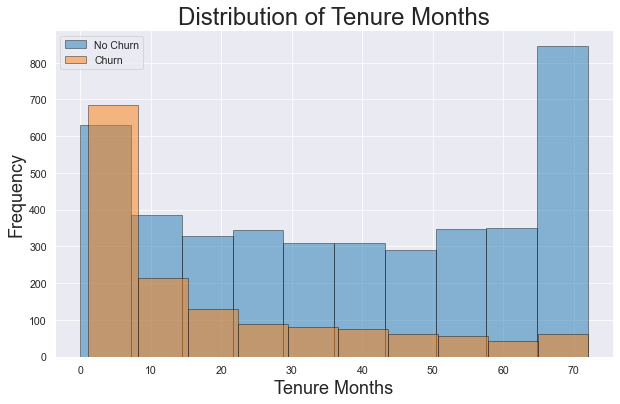

In [24]:
# histogram of the height
tc2[tc2['churn_value'] == 0].tenure_months.plot(kind='hist', color='tab:blue', edgecolor='black', alpha=0.5, figsize=(10,6))
tc2[tc2['churn_value'] == 1].tenure_months.plot(kind='hist', color='tab:orange', edgecolor='black', alpha=0.5, figsize=(10,6))
plt.legend(labels=['No Churn', 'Churn'])
plt.title('Distribution of Tenure Months', size=24)
plt.xlabel('Tenure Months', size=18)
plt.ylabel('Frequency', size=18)
plt.tight_layout
plt.show()

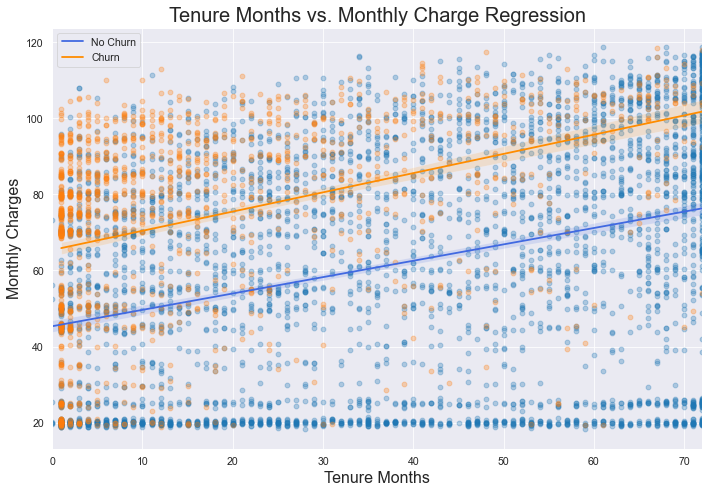

In [25]:
# regression plot using seaborn
tc2_0 = tc2[tc2['churn_value'] == 0]
tc2_1 = tc2[tc2['churn_value'] == 1]

fig = plt.figure(figsize=(10, 7))
sns.regplot(data=tc2_0, x='tenure_months', y='monthly_charges', 
            scatter_kws = {'color': 'tab:blue', 'alpha' : 0.3}, 
            line_kws={'color' : 'royalblue'}) 
sns.regplot(data=tc2_1, x='tenure_months', y='monthly_charges', 
            scatter_kws = {'color': 'tab:orange', 'alpha' : 0.3}, 
            line_kws={'color' : 'darkorange'})

# Legend, title and labels.
plt.legend(labels=['No Churn', 'Churn'])
plt.title('Tenure Months vs. Monthly Charge Regression', size=20)
plt.xlabel('Tenure Months', size=16)
plt.ylabel('Monthly Charges', size=16)
plt.tight_layout()
plt.show()

## Tableau Charts

### Demographics Churn Rate

<img align="left" width="800" src="images/tab_db_key_attr_churn_rate.png">

### Tenure-Contract Churn

<img align="left" width="800" height="600" src="images/tab_sheet_tenure_contract.png">

### Charges-Tenure Scatter

<img align="left" width="800" height="600" src="images/tab_sheet_tenure_charges.png">

### Product Group Churn

<img align="left" width="800" height="600" src="images/tab_sheet_prod_contract.png">

## Correlation

In [396]:
# create column correlation matrix
corr = tc2.corr()

# limit to churn target and drop non-predictive fields
corr_churn = corr.copy().loc[:, 'churn_value'].sort_values(ascending=False)
to_drop = ['zip_code', 'count', 'churn_value', 'churn_score', 
           'churn_rsn_grp_product', 'churn_rsn_grp_cust_svc', 
           'churn_rsn_grp_pricing', 'churn_rsn_grp_moved', 
           'churn_rsn_grp_unknown']
corr_churn = corr_churn.drop(to_drop)
corr_churn

contract_mtm              0.402
pmt_meth_echeck           0.303
internet_svc_fiber        0.302
p8_fib_bund_plus          0.210
p7_fib_bund_core          0.199
monthly_charges           0.193
paperless_billing         0.189
senior_citizen            0.136
streams                   0.078
streaming_movies          0.074
p3_dsl_only               0.062
streaming_tv              0.062
p5_dsl_bund_core          0.059
multiple_lines            0.049
phone_service             0.011
gender_female             0.010
gender_male              -0.010
charge_trend_index       -0.019
p4_dsl_plus              -0.045
device_protection        -0.062
online_backup            -0.078
charge_cust_index        -0.093
pmt_meth_mail_check      -0.096
pmt_meth_bank_trx_auto   -0.113
p2_phone_multi           -0.116
internet_svc_dsl         -0.119
cltv                     -0.132
svc_add_ons              -0.133
pmt_meth_cc_auto         -0.135
partner                  -0.140
p6_dsl_bund_plus         -0.155
tech_sup

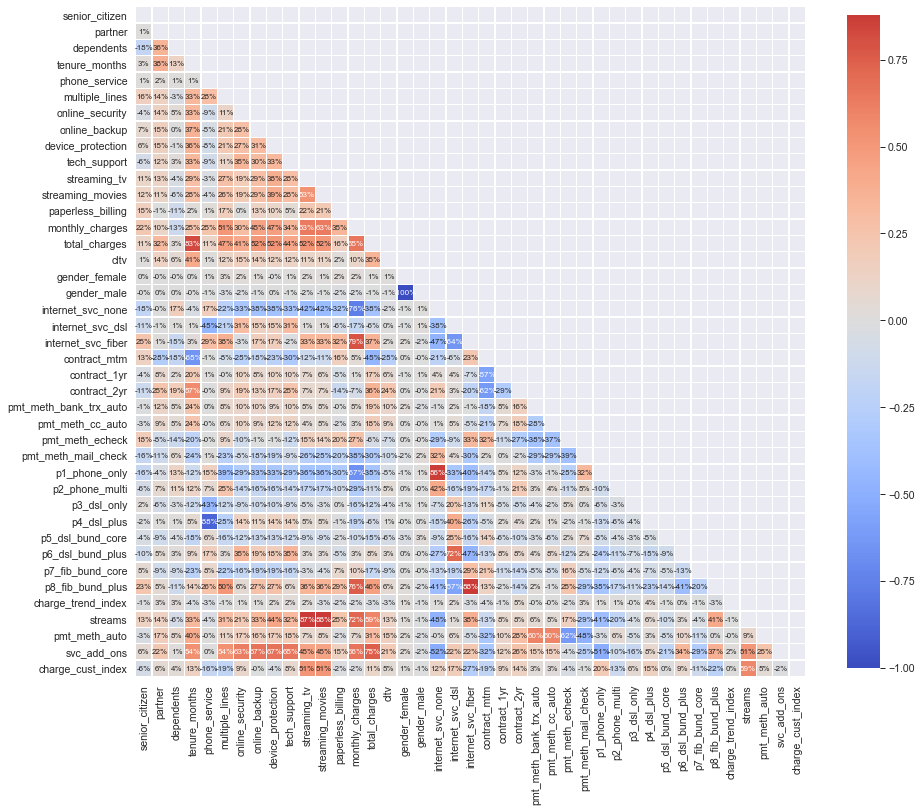

In [421]:
# show heatmap for correlation matrix
f, ax = plt.subplots(figsize=(15,15))
corr2 = corr.drop(to_drop).drop(to_drop, axis=1)
mask = np.zeros(corr2.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(corr2, mask = mask, fmt='.0%',
            center=0, linewidths=0.3, cmap='coolwarm', square=True, 
            annot=True, cbar_kws={'shrink': 0.8}, annot_kws={'size': 8})
plt.tight_layout
plt.show()

In [422]:
# check for collinearity among potential predictors by pairs
df = (
     corr2
     .stack()
     .reset_index()
     .sort_values(0, ascending=False)
)
# zip the default name columns level_0 and level_1
df['pairs'] = list(zip(df.level_0, df.level_1))
# set index to pairs
df.set_index(['pairs'], inplace=True)
# now drop level columns
df.drop(columns=['level_1', 'level_0'], inplace=True)
# rename correlation column rather than 0
df.columns = ['correlation']
# drop duplicates and keep only pair correlations above 0.65
df.drop_duplicates(inplace=True)
df[abs(df.correlation) > .60]

,correlation
pairs,
"(senior_citizen, senior_citizen)",1.000
"(p8_fib_bund_plus, internet_svc_fiber)",0.878
"(streams, streaming_movies)",0.875
"(streaming_tv, streams)",0.875
"(p1_phone_only, internet_svc_none)",0.865
"(total_charges, tenure_months)",0.827
"(monthly_charges, internet_svc_fiber)",0.789
"(monthly_charges, p8_fib_bund_plus)",0.759
"(svc_add_ons, total_charges)",0.749


# Churn Models

## Functions

This section holds common functions for use across multiple model types

### display_confusion

In [586]:
# plot confusion matrix for classifier object
def display_confusion(model, X, y, labels=None):
    """Plots confusion matrix for a classifier model results

    Parameters:
    - model (classifier): model refit with best estimator during gridsearch
    - X (pd.DataFrame): independent X variables as input to model
    - y (array): y values (can be actual or predicted churn values)
    - labels (str): labels for predicted and actual values

    Returns: none
    """
    plot_confusion_matrix(model, X, y, cmap=plt.cm.Blues, 
                          display_labels=labels)
    confusion_matrix(y_test, y_pred_adj)
    plt.grid(False)     
    plt.tight_layout()
    plt.show()

### display_class_report

In [591]:
# plot confusion matrix for classifier object
def display_class_report(y_true, y_hat):
    """Prints classification report for a classifier model predictions.

    Parameters:
    - y_true (pd.Series): true north y values (actual churn values)
    - y_hat (array): model predictions for y    

    Returns: none
    """
    print(pd.DataFrame(confusion_matrix(y_true, y_hat),
                       columns=['Retain Pred', 'Churn Pred'], 
                       index=['Retain Actual', 'Churn Actual']))
    print(classification_report(y_true, y_hat))

### drop_features

In [676]:
# function drops columns not needed for model from dataframe
def drop_features(X_df, drop_list):
    """Drops list of columns on a dataframe prior to running a model. Can be
    used for training or test data.

    Parameters:
    - X_df (pd.DataFrame): dataframe containing all X features/columns
    - drop_list (list): columns to drop from X_df

    Returns:
    - X_df_tr (pd.DataFrame)
    """    
    X_df_tr = X_df.drop(drop_list, axis=1, inplace=False)
    return X_df_tr

### instantiate_grid

In [674]:
# function to create standard gridsearchCV object
def instantiate_grid(model, grid_params, refit='roc_auc'):
    """Creates a GridSearchCV object using estimator (model) applying grid 
    parameters and standard scoring metrics. 

    Parameters:
    - model (classifier): model estimator to use during grid search
    - grid_params (dict): lists of parameters for grid search iterations
    - refit (str): indicators scoring metric to refit best estimator

    Returns:
    - gs (object): GridSearchCV instantiation object
    """    
    # set common scoring metrics for use across models
    scoring = {'roc_auc': make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=False), 
               'accuracy': make_scorer(accuracy_score), 
               'precision': make_scorer(precision_score), 
               'recall': make_scorer(recall_score), 
               'f1': make_scorer(f1_score)
              }
    
    # GridSearch uses 5 cross-validation folds within each training iteration
    gs = GridSearchCV(estimator=model, param_grid=grid_params, 
                      scoring=scoring, refit=refit, 
                      cv=StratifiedKFold(n_splits=5, random_state=SEED, 
                                     shuffle=True))
    
    return gs

### show_grid_metrics

In [679]:
# key metrics to evaluate model performance
def show_grid_metrics(cv_results, sort_by, top_n=10):
    """Extracts and displays top n sorted rows of evaluation metrics from 
    cross-validation results of a grid search.

    Parameters:
    - cv_results (DataFrame): full cross-validation results from grid search
    - sort_by (str): scoring metric to sort descending high-to-low
    - top_n (int): number of rows to display

    Returns:
    - cv_results_metrics (DataFrame): metrics for each model iteration
    """
    # define evaluation metrics to keep from cv results
    metrics = ['params', 'mean_test_roc_auc', 'mean_test_accuracy', 
               'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 
               'rank_test_roc_auc', 'rank_test_recall']

    cv_results_metrics = cv_results.loc[:, metrics]
    cv_results_metrics.sort_values(by=[sort_by], ascending=False, 
                                   inplace=True)
    display(cv_results_metrics[:top_n])
    return cv_results_metrics

### feature_importance

In [680]:
#
def feature_importance(model, X_df):
    """Extracts and plots relative feature importance based on classifier
    model coefficients.

    Parameters:
    - model (classifier): model estimator to use during grid search
    - X_df (pd.DataFrame): dataframe containing all X features/columns

    Returns:
    - coef_table (DataFrame): coefficient table by feature
    """    
    # create feature coefficient dataframe
    coef_table = pd.DataFrame(X_df.columns, columns=['feature'])
    coef_table.insert(1, 'coef', model.coef_.transpose())

    # plot feature coefficient on bar graph
    fig = plt.figure(figsize=(18, 8))
    sns.barplot(x='feature', y='coef', data=coef_table, palette='vlag')
    plt.title('Model Coefficients by Feature', size=20)
    plt.xlabel('Feature', size=16)
    plt.ylabel('Model Coefficient', size=16)
    plt.xticks(rotation=-80)
    plt.tight_layout()
    plt.show()
    
    return coef_table

### score_pred

In [554]:
# calculates model evaluation metrics by comparing predictions to "true north"
def score_pred(model_type, data_type, y_true, y_hat):
    """Calculates and returns ROC AUC, accuracy, recall, precision, f1 score; 
    prints compact results summary.

    Parameters:
    - model_type (str): identifes type of model (eg. 'rf' = random forest)
    - data_type (str): indicates if y values are from train or test results
    - y_true (pd.Series): true north y values (actual churn values)
    - y_hat (array): model predictions for y

    Returns:
    - scores (dict): includes 5 evaluation metrics for model type
    """
    scores = {}
    scores['model'] = model_type
    scores['data'] = data_type
    scores['auc'] = roc_auc_score(y_true, y_hat)
    scores['acc'] = accuracy_score(y_true, y_hat)
    scores['rec'] = recall_score(y_true, y_hat)
    scores['prec'] = precision_score(y_true, y_hat)
    scores['f1'] = f1_score(y_true, y_hat)   
    print(f'Model {scores["model"]} Predictions: AUC {round(scores["auc"], 2)} | '
          f'Accuracy {round(scores["acc"], 2)} | '
          f'Recall {round(scores["rec"], 2)} | '
          f'Precision {round(scores["prec"], 2)} | '
          f'F1 {round(scores["f1"], 2)}' )

    return scores

### assign_class

In [594]:
def assign_class(y_hat_prob, dt=0.5):
    """
    Calculates churn predictions based on any decision threshold level 
    using a classification model's predicted probability scores.
    
    Parameters:
    - y_hat_prob (array): predicted churn probabilities
    - dt (float): decision threshold value between 0 and 1. Represents 
      predicted probability at which postive class (churn) should be assigned.

    Returns:
    - scores (dict): includes 5 evaluation metrics for model type
    """
    return [1 if y >= dt else 0 for y in y_hat_prob]

### plot_pr_curve

In [712]:
def plot_pr_curve(p, r, thresholds, model_type, dt=[0.5]):
    """
    Plots the precision-recall curve indicating the current values for a
    classifier decision threshold. Default classifier models use >= 0.5.
   
    Parameters:
    - p (array): precision value at certain threshold
    - r (array): recall value at certain threshold
    - thresholds (array): probability threshold where positive class is assigned
    - dt (float): decision threshold value between 0 and 1. Represents 
      desired probability at which postive class (churn) should be assigned.
    - model_type (str): Text for model type title

    Returns: None
    """
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title(f'{model_type} | Precision-Recall Curve | Shows Decision Thresholds')
    plt.step(r, p, color='b', alpha=0.2, where='post')
    plt.fill_between(r, p, step='post', alpha=0.2, color='b')
    plt.ylim([0, 1.01])
    plt.xlim([0, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # plot the current threshold on the line
    for t in dt:
        dt_point = np.argmin(np.abs(thresholds - t))
        dt_label = 'DT = '+str(t)
        plt.plot(r[dt_point], p[dt_point], 'o', c='k', markersize=12)
        plt.annotate(dt_label, 
                     (r[dt_point], p[dt_point]),
                     textcoords="offset points", 
                     xytext=(0,12), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center


### plot_pr_vs_dt

In [708]:
def plot_pr_vs_dt(p, r, thresholds, model_type):
    """
    Plots precision and recall lines (y) for each value of classifier decision
    threshold (x). Default classifier models use >= 0.5.
   
    Parameters:
    - p (array): precision value at certain threshold
    - r (array): recall value at certain threshold
    - thresholds (array): probability threshold where positive class is assigned
    - model_type (str): Text for model type title

    Returns: None
    """
    plt.figure(figsize=(8, 8))
    plt.title(f'{model_type} | Precision-Recall Scores vs. Decision Threshold')
    plt.plot(thresholds, p[:-1], 'b--', label='Precision')
    plt.plot(thresholds, r[:-1], 'g-', label='Recall')
    plt.ylabel('Score')
    plt.xlabel('Decision Threshold')
    plt.legend(loc='best')

## m0 Dummy Classifier

In [762]:
# establish dummy model and score accuracy
dum = DummyClassifier(strategy='stratified')
dum.fit(X_train, y_train)
y_hat_train_m0 = dum.predict(X_train)
print(f'Dummy Model Accuracy: {round(dum.score(y_train, y_hat_train_m0), 2)}')

Dummy Model Accuracy: 0.62


## m1 Decision Tree Vanilla

In [38]:
# define features to drop from X_train through iterations; not significant
m1_drops = ['customerid', 'count', 'country', 'city', 'state', 'zip_code', 
            'lat_long', 'churn_score', 'cltv', 'churn_reason', 
            'churn_rsn_grp_cust_svc', 'churn_rsn_grp_moved', 
            'churn_rsn_grp_pricing', 'churn_rsn_grp_product', 
            'churn_rsn_grp_unknown']

X_train1 = drop_features(X_train, m1_drops)
X_test1 = drop_features(X_test, m1_drops)
X_train1.head()

,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,gender_female,gender_male,internet_svc_none,internet_svc_dsl,internet_svc_fiber,contract_mtm,contract_1yr,contract_2yr,pmt_meth_bank_trx_auto,pmt_meth_cc_auto,pmt_meth_echeck,pmt_meth_mail_check,monthly_charge_life_avg,streams,pmt_meth_auto,svc_add_ons
2396,0,0,0,2,1,0,0,0,0,0,0,0,1,20.550,33.600,1,0,1,0,0,1,0,0,0,0,0,1,16.800,0,0,0
6365,0,0,0,40,1,1,0,0,0,0,0,1,0,83.850,"3,532.250",1,0,0,0,1,1,0,0,1,0,0,0,88.306,1,1,1
5898,0,0,0,26,1,0,0,1,1,0,0,0,1,56.050,"1,553.200",1,0,0,1,0,0,1,0,0,0,0,1,59.738,0,0,2
12,0,0,1,34,1,1,0,1,1,0,1,1,1,106.350,"3,549.250",0,1,0,0,1,1,0,0,0,0,1,0,104.390,2,0,3
5065,0,0,0,11,1,0,1,0,0,0,0,0,0,76.400,838.700,1,0,0,0,1,1,0,0,0,0,1,0,76.245,0,0,1


In [39]:
# train a DT classifier using training data 
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=SEED, 
                                 max_depth=3)
dt.fit(X_train1, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=19)

Logistic Regression Confusion Matrix - Training Data


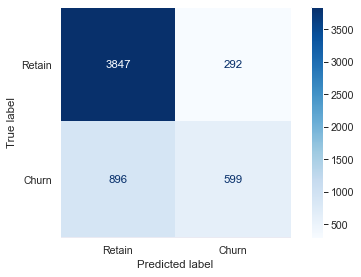

Best Model Parameters: <bound method BaseEstimator.get_params of DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=19)>


In [752]:
# print confusion matrix (train) for best model
best_model_rf = dt
print('Logistic Regression Confusion Matrix - Training Data')
display_confusion(dt, X_train1, y_train, labels=['Retain', 'Churn'])
print(f'Best Model Parameters: {dt.get_params}')

In [754]:
# compare Decision Tree metrics for Train vs Test data sets
print('Train Performance - Decision Tree\n---------------------------------')
y_hat_train1 = dt.predict(X_train1)
scores_train_dt = score_pred('dt', 'train', y_train, y_hat_train1)

print('\nTest Performance - Decision Tree\n--------------------------------')
y_hat_test1 = dt.predict(X_test1)
scores_test_dt = score_pred('dt', 'test', y_test, y_hat_test1)

Train Performance - Decision Tree
---------------------------------
Model dt Predictions: AUC 0.67 | Accuracy 0.79 | Recall 0.4 | Precision 0.67 | F1 0.5

Test Performance - Decision Tree
--------------------------------
Model dt Predictions: AUC 0.68 | Accuracy 0.8 | Recall 0.42 | Precision 0.71 | F1 0.53


**Decision Tree Notes: Train vs. Test**
- Each evaluation metric for Test is slightly better than Train by 0.01 to 0.03.
- Given similarity, feel comfortable model is not overfitting train.

Decision Tree Confusion Matrix - Test Data


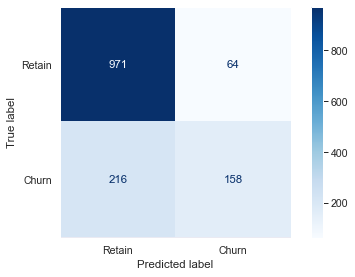

               Retain Pred  Churn Pred
Retain Actual          971          64
Churn Actual           216         158
              precision    recall  f1-score   support

           0       0.82      0.94      0.87      1035
           1       0.71      0.42      0.53       374

    accuracy                           0.80      1409
   macro avg       0.76      0.68      0.70      1409
weighted avg       0.79      0.80      0.78      1409



In [755]:
# print confusion matrix for best Decision Tree model on test data
print(f'Decision Tree Confusion Matrix - Test Data')
display_confusion(dt, X_test1, y_test, labels=['Retain', 'Churn'])
display_class_report(y_test, y_hat_test1)

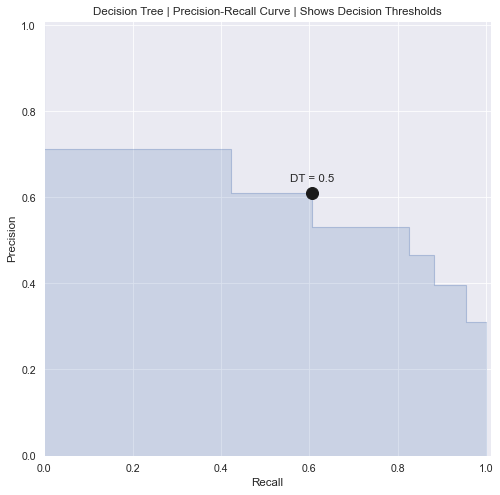

In [756]:
# generate Decision Tree predict probabilities; store precision-recall curve values
y_hat_prob_test1 = dt.predict_proba(X_test1)[:, 1]
p1, r1, thresholds1 = precision_recall_curve(y_test, y_hat_prob_test1)

# plot precision-recall curve for baseline decision threshold 0.5
plot_pr_curve(p1, r1, thresholds1, 'Decision Tree', dt=[0.5])

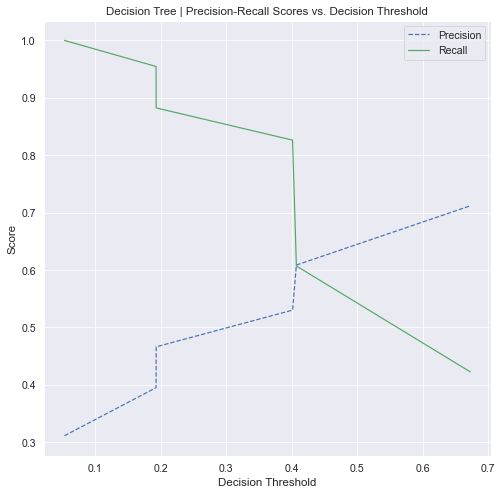

In [757]:
# plot precision and recall against decision threshold options
plot_pr_vs_dt(p1, r1, thresholds1, 'Decision Tree')

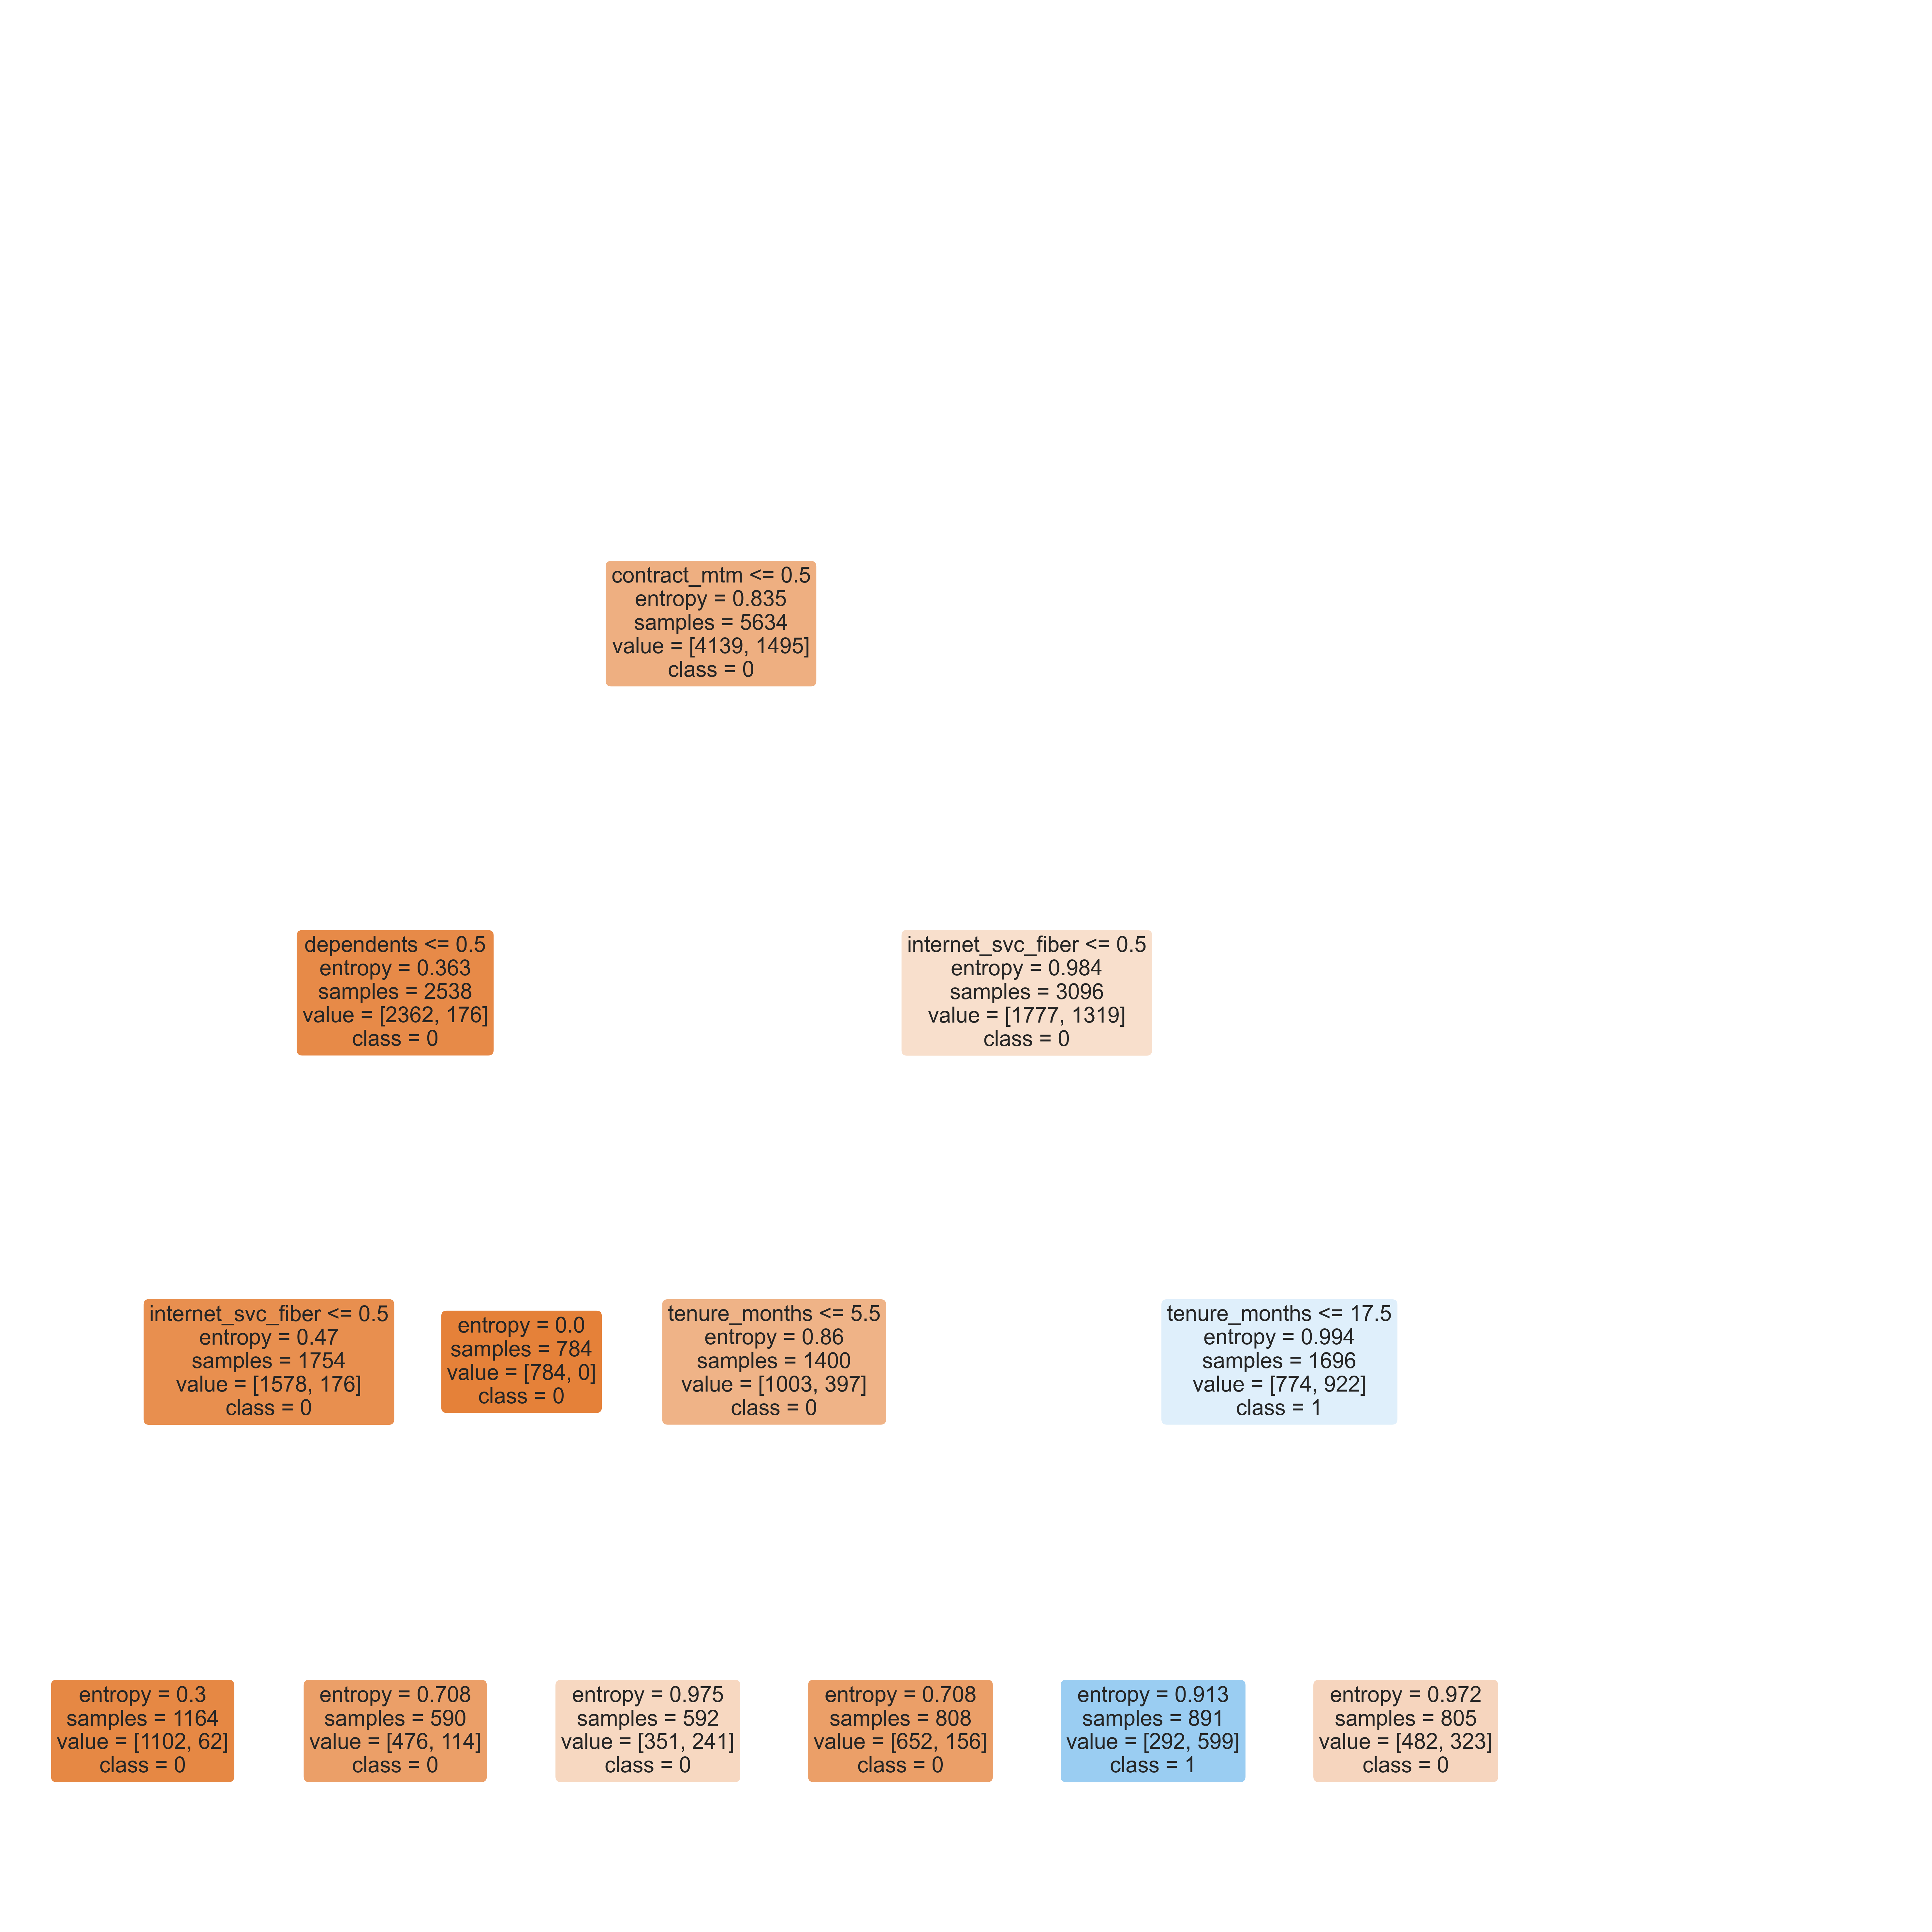

In [758]:
# Plot and show decision tree
plt.figure(figsize=(12,12), dpi=500)
tree.plot_tree(dt, feature_names=X_train1.columns,
               class_names=np.unique(y_train).astype('str'),
               filled=True, rounded=True)
plt.tight_layout()
plt.show()

## m2 Logistic Regression

### Create Model

In [53]:
# define features to drop from X_train through iterations; not significant
m2_drops = ['customerid', 'count', 'country', 'city', 'state', 'streaming_movies', 
           'streaming_tv', 'zip_code', 'lat_long', 'churn_score', 'cltv', 
           'senior_citizen', 'phone_service', 'churn_reason', 
           'churn_rsn_grp_cust_svc', 'churn_rsn_grp_moved', 'churn_rsn_grp_pricing', 
           'churn_rsn_grp_product', 'churn_rsn_grp_unknown', 
           'monthly_charge_life_avg', 'online_security', 'online_backup', 
           'device_protection', 'tech_support', 'multiple_lines', 'total_charges', 
           'gender_female', 'gender_male' ,'internet_svc_none', 'svc_add_ons', 
           'pmt_meth_mail_check', 'pmt_meth_cc_auto', 'pmt_meth_bank_trx_auto', 
           'pmt_meth_echeck', 'contract_mtm']

In [66]:
# apply drop columns against X_train and X_test for model 2
X_train2 = drop_features(X_train, m2_drops)
X_test2 = drop_features(X_test, m2_drops)

In [741]:
# document features included in Logistic Regression model
print(f'Model 2 Logistic Regression: {X_train2.shape[0]} rows | {X_train2.shape[1]} features')
print(f'Features included:\n{X_train2.columns}')

Model 2 Logistic Regression: 5634 rows | 11 features
Features included:
Index(['partner', 'dependents', 'tenure_months', 'paperless_billing',
       'monthly_charges', 'internet_svc_dsl', 'internet_svc_fiber',
       'contract_1yr', 'contract_2yr', 'streams', 'pmt_meth_auto'],
      dtype='object')


In [67]:
# fit scaler to training data and transform both train and test dataframes
scaler = StandardScaler()
X_train2[X_train2.columns] = scaler.fit_transform(X_train2[X_train2.columns])
X_test2[X_test2.columns] = scaler.transform(X_test2[X_test2.columns])

In [68]:
# create Logistic Regression classifier object
model_lr = LogisticRegression(random_state=SEED, fit_intercept=False, max_iter=500, n_jobs=jobs)

### Run GridSearchCV

In [64]:
# define the grid for Logistic Regression
c_params = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

grid_params_lr = [{'C' : c_params, 'solver' : ['liblinear', 'saga'], 
                   'penalty': ['l1', 'l2'], 
                   'class_weight' : [None, 'balanced', 
                                         {1:2, 0:1}, {1:3, 0:1}, {1:5, 0:1}]}]

In [60]:
# create gridsearchCV object for Logistic Regression
gs_lr = instantiate_grid(model_lr, grid_params_lr)

In [61]:
# execute the Logistic Regression gridsearchCV on training data
gs_lr.fit(X_train2, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=LogisticRegression(fit_intercept=False, max_iter=500,
                                          n_jobs=4, random_state=19),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'class_weight': [None, 'balanced', {0: 1, 1: 2},
                                           {0: 1, 1: 3}, {0: 1, 1: 5}],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']}],
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

### Model Performance

In [742]:
# print confusion matrix (train) for best model
best_model_lr = gs_lr.best_estimator_
print('Logistic Regression Confusion Matrix - Training Data')
display_confusion(best_model_lr, X_train2, y_train, labels=['Retain', 'Churn'])
print(f'Best Model Parameters: {gs_lr.best_index_} {gs_lr.best_estimator_.get_params}')

Logistic Regression Confusion Matrix - Training Data


ValueError: X has 11 features per sample; expecting 29

In [743]:
# plot Random Forest feature importance for best estimator
feature_importance(best_model_lr, X_train2)

ValueError: Length of values (29) does not match length of index (11)

**Logistic Regression Notes: Feature Importance**
-d

In [744]:
# display top model results
cv_results2 = pd.DataFrame.from_dict(gs_lr.cv_results_)
cv_results_metrics2 = show_grid_metrics(cv_results2, 'mean_test_roc_auc', top_n=5)

,params,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_roc_auc,rank_test_recall
30,"{'C': 0.01, 'class_weight': {1: 2, 0: 1}, 'penalty': 'l2', 'solver': 'liblinear'}",0.763,0.702,0.468,0.894,0.614,1,73
31,"{'C': 0.01, 'class_weight': {1: 2, 0: 1}, 'penalty': 'l2', 'solver': 'saga'}",0.763,0.702,0.468,0.894,0.614,1,73
83,"{'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}",0.762,0.709,0.474,0.876,0.615,3,121
82,"{'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}",0.762,0.709,0.474,0.876,0.615,3,121
122,"{'C': 1000, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}",0.762,0.709,0.474,0.876,0.615,5,121


### Predict Test

This section applies the best Logistic Regression estimator from above to unseen 20% Test holdout data. Below charts and plots evaluate predictive performance and insights.

In [745]:
# compare Logistic Regression best estimator metrics for Train vs Test data sets
print('Train Performance - Logistic Regression\n---------------------------------')
y_hat_train2 = gs_lr.predict(X_train2)
scores_train_lr = score_pred('lr', 'train', y_train, y_hat_train2)

print('\nTest Performance - Logistic Regression\n--------------------------------')
y_hat_test2 = gs_lr.predict(X_test2)
scores_test_lr = score_pred('lr', 'test', y_test, y_hat_test2)

Train Performance - Random Forest
---------------------------------


ValueError: X has 11 features per sample; expecting 29

**Logistic Regression Notes: Train vs. Test**
- Each evaluation metric for Test is slightly better than Train by 0.01 to 0.03.
- Given similarity, feel comfortable model is not overfitting train.

In [746]:
# print confusion matrix for best Logistic Regression model on test data
best_model_lr = gs_lr.best_estimator_
print(f'Logistic Regression Confusion Matrix - Test Data - Best Model {gs_lr.best_index_}')
display_confusion(best_model_lr, X_test2, y_test, labels=['Retain', 'Churn'])
display_class_report(y_test, y_hat_test2)

Random Forest Confusion Matrix - Test Data - Best Model 30


ValueError: X has 11 features per sample; expecting 29

**Logistic Regression Notes: Confusion Matrix**
- Somewhat pleased with 72% churn precision (we can predict 3/4 churn cases)
- Model recall of 46% is weak, can only cover half the actual churn cases.
- Explore precision-recall curve for options on decision threshold to increase precision

In [748]:
# generate Logistic Regression predict probabilities; store precision-recall curve values
y_hat_prob_test2 = gs_lr.predict_proba(X_test2)[:, 1]
p2, r2, thresholds2 = precision_recall_curve(y_test, y_hat_prob_test2)

# plot precision-recall curve for baseline decision threshold 0.5
plot_pr_curve(p2, r2, thresholds2, 'Logistic Regression', dt=[0.5])

ValueError: X has 11 features per sample; expecting 29

**Logistic Regression Notes: Precision-Recall Curve**
- Default model uses 0.5 decision threshold show by circle on plot
- DT 0.5 lines up with recall = 0.46 and precision = 0.72
- Interested in finding DT for higher precision points as recommendation

In [750]:
# plot precision and recall against decision threshold options
plot_pr_vs_dt(p2, r2, thresholds2, 'Logistic Regression')

NameError: name 'p2' is not defined

**Logistic Regression Notes: Decision Threshold Options**
- Will recommend multi-tier solution based on several thresholds
- High cost solutions need higher precision to prevent overpredict churn
- Precision Breakpoints (Medium/Low incremental excluding higher levels):
    - **High**: DT=0.67-0.70 / 82% Precision / 15% Recall (55 true pos, 12 false pos)
    - **Medium**: DT=0.55-0.67 / 73% Precision / 27% Recall (103 true pos, 38 false pos)
    - **Low**: DT=0.45-0.55 / 50% Precision / 22% Recall (82 true pos, 83 false pos)
- Combining 3 tiers: Average Precision 64% covering 64% churn cases
- Not recommended: DT 0.1-0.45 / 36% Precision / 36% additional recall

In [ ]:
# revised class predictions using decision threshold 0.50
y_hat_high_test2 = assign_class(y_hat_prob_test2, dt=0.50)
# confusion_matrix(y_test, y_pred_adj)
display_class_report(y_test, y_hat_high_test2)

In [ ]:
# plot the ROC Area Under Curve for Logistic Regression
fpr2, tpr2, auc_thresholds2 = roc_curve(y_test, y_hat_test2)
print(f'Logistic Regression Model AUC {round(auc(fpr2, tpr2), 3)}') # AUC of ROC
plot_roc_curve(fpr2, tpr2, 'Logistic Regression')

### Statsmodel Logit

In [71]:
# Fit the training data
sm_lr = sm.Logit(y_train, sm.add_constant(X_train2)).fit()
print(sm_lr.summary())

Optimization terminated successfully.
         Current function value: 0.407370
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            churn_value   No. Observations:                 5634
Model:                          Logit   Df Residuals:                     5622
Method:                           MLE   Df Model:                           11
Date:                Fri, 16 Apr 2021   Pseudo R-squ.:                  0.2959
Time:                        10:19:23   Log-Likelihood:                -2295.1
converged:                       True   LL-Null:                       -3259.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.7290      0.055    -31.551      0.000      -1.836      -1.622
partn

**Logistic Regression: Statsmodel Summary**
- asdf


## m3 Random Forest

### Create Model

In [689]:
# define features to drop from X_train through iterations; not significant
m3_drops = ['customerid', 'count', 'country', 'city', 'state',  'zip_code', 
            'lat_long', 'churn_score', 'cltv', 'churn_reason', 'churn_rsn_grp_cust_svc', 
            'churn_rsn_grp_moved', 'churn_rsn_grp_pricing', 'churn_rsn_grp_product', 
            'churn_rsn_grp_unknown', 'online_security', 'online_backup',  
            'device_protection', 'multiple_lines','phone_service', 'tech_support', 
            'internet_svc_dsl', 'internet_svc_fiber', 'p1_phone_only',  
            'internet_svc_none', 'svc_add_ons', 'streaming_movies', 'streaming_tv',
            'gender_female', 'gender_male' ,  'senior_citizen', 'total_charges', 
            'charge_trend_index', 'monthly_charges', 'pmt_meth_mail_check', 
            'pmt_meth_cc_auto', 'pmt_meth_bank_trx_auto', 'pmt_meth_echeck', 
            'contract_mtm']

In [690]:
# apply drop columns against X_train and X_test for model 3
X_train3 = drop_features(X_train, m3_drops)
X_test3 = drop_features(X_test, m3_drops)

In [691]:
# document features included in Random Forest model
print(f'Model 3 Random Forest: {X_train3.shape[0]} rows | {X_train3.shape[1]} features')
print(f'Features included:\n{X_train3.columns}')

Model 3 Random Forest: 5634 rows | 16 features
Features included:
Index(['partner', 'dependents', 'tenure_months', 'paperless_billing',
       'contract_1yr', 'contract_2yr', 'p2_phone_multi', 'p3_dsl_only',
       'p4_dsl_plus', 'p5_dsl_bund_core', 'p6_dsl_bund_plus',
       'p7_fib_bund_core', 'p8_fib_bund_plus', 'streams', 'pmt_meth_auto',
       'charge_cust_index'],
      dtype='object')


In [693]:
# fit scaler to training data; transform both train and test dataframes
scaler = StandardScaler()
X_train3[X_train3.columns] = scaler.fit_transform(X_train3[X_train3.columns])
X_test3[X_test3.columns] = scaler.transform(X_test3[X_test3.columns])

In [460]:
# create Random Forest classifier object
model_rf = RandomForestClassifier(random_state=SEED, n_jobs=jobs)

### Run GridSearchCV

In [461]:
# define the grid for Random Forest
grid_params_rf = [{'criterion': ['gini', 'entropy'], # measures split quality
                   'class_weight': ['balanced'], # adjust imbalanced positive class
                   'n_estimators': [50, 100, 200, 500], # number trees to grow            
                   'max_features': ['auto', 6, None], # features considered at splits
                   'max_depth': [4, 6, 8, 10],  # max nodes in each tree
                   'min_samples_leaf': [5, 10, 15], # samples required in each leaf
                   'min_samples_split': [0.1, 0.2, 0.3, 0.4], # percentage required to split node
                    }]

In [462]:
# create gridsearchCV object for Random Forest
gs_rf = instantiate_grid(model_rf, grid_params_rf)

In [463]:
# execute the Random Forest gridsearchCV on training data
gs_rf.fit(X_train3, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=19),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [4, 6, 8, 10],
                          'max_features': ['auto', 6, None],
                          'min_samples_leaf': [5, 10, 15],
                          'min_samples_split': [0.1, 0.2, 0.3, 0.4],
                          'n_estimators': [50, 100, 200, 500]}],
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

### Model Performance

Random Forest Confusion Matrix - Training Data


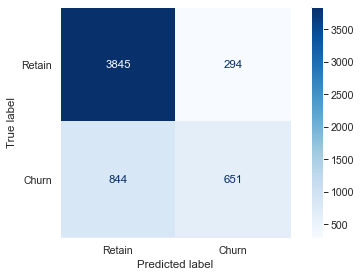

Best Model Parameters: 960 <bound method BaseEstimator.get_params of RandomForestClassifier(criterion='entropy', max_depth=8, max_features=None,
                       min_samples_leaf=5, min_samples_split=0.1,
                       n_estimators=50, n_jobs=-1, random_state=19)>


In [698]:
# print confusion matrix (train) for best model
best_model_rf = gs_rf.best_estimator_
print('Random Forest Confusion Matrix - Training Data')
display_confusion(best_model_rf, X_train3, y_train, labels=['Retain', 'Churn'])
print(f'Best Model Parameters: {gs_rf.best_index_} {gs_rf.best_estimator_.get_params}')

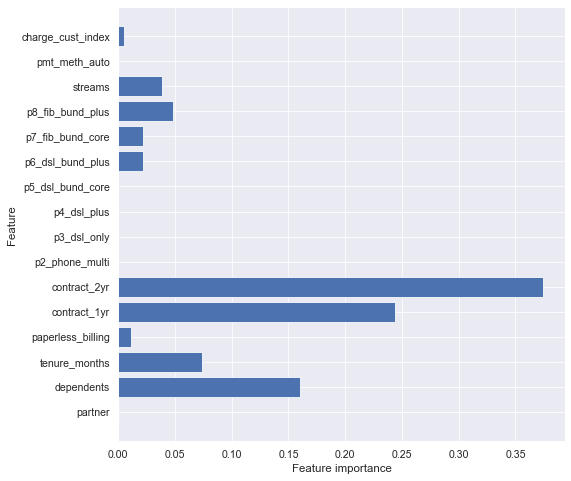

In [696]:
# plot Random Forest feature importance for best estimator
feature_importance_rf(best_model_rf, X_train3)

**Random Forest Notes: Feature Importance**
- Contract Type: Contracts 2yr/1yr (versus MTM) by far most influential
- Dependents: Very influential if customer supports kids/elders
- Tenure: Lenght of customer tenure is strong factor
- Products: Product profiles containing Internet Fiber (p6/p7/p8) are moderate
- Streams: Moderate if customer streams TV or movies
- Other Lows: Paperless billing, customer charges relative to index
- No influence: Automatic payment method, products p2-p5, has partner

In [697]:
# display top model results
cv_results3 = pd.DataFrame.from_dict(gs_rf.cv_results_)
cv_results_metrics3 = show_grid_metrics(cv_results3, 'mean_test_roc_auc', top_n=5)

,params,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_roc_auc,rank_test_recall
976,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 0.1, 'n_estimators': 50}",0.679,0.790,0.662,0.441,0.527,1,1
1104,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 0.1, 'n_estimators': 50}",0.679,0.790,0.662,0.441,0.527,1,1
992,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 0.1, 'n_estimators': 50}",0.679,0.790,0.662,0.441,0.527,1,1
960,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 0.1, 'n_estimators': 50}",0.679,0.790,0.662,0.441,0.527,1,1
1136,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 0.1, 'n_estimators': 50}",0.679,0.790,0.662,0.441,0.527,1,1


### Predict Test

This section applies the best Random Forest estimator from above to unseen 20% Test holdout data. Below charts and plots evaluate predictive performance and insights.

In [699]:
# compare random forest best estimator metrics for Train vs Test data sets
print('Train Performance - Random Forest\n---------------------------------')
y_hat_train3 = gs_rf.predict(X_train3)
scores_train_rf = score_pred('rf', 'train', y_train, y_hat_train3)

print('\nTest Performance - Random Forest\n--------------------------------')
y_hat_test3 = gs_rf.predict(X_test3)
scores_test_rf = score_pred('rf', 'test', y_test, y_hat_test3)

Train Performance - Random Forest
---------------------------------
Model rf Predictions: AUC 0.68 | Accuracy 0.8 | Recall 0.44 | Precision 0.69 | F1 0.53

Test Performance - Random Forest
--------------------------------
Model rf Predictions: AUC 0.7 | Accuracy 0.81 | Recall 0.46 | Precision 0.72 | F1 0.56


**Random Forest Notes: Train vs. Test**
- Each evaluation metric for Test is slightly better than Train by 0.01 to 0.03.
- Given similarity, feel comfortable model is not overfitting train.

Random Forest Confusion Matrix - Test Data - Best Model 960


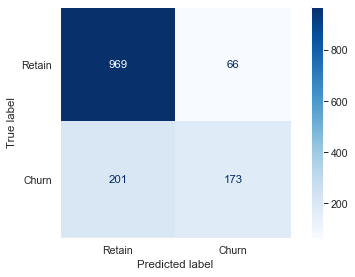

               Retain Pred  Churn Pred
Retain Actual          969          66
Churn Actual           201         173
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1035
           1       0.72      0.46      0.56       374

    accuracy                           0.81      1409
   macro avg       0.78      0.70      0.72      1409
weighted avg       0.80      0.81      0.80      1409



In [700]:
# print confusion matrix for best random forest model on test data
best_model_rf = gs_rf.best_estimator_
print(f'Random Forest Confusion Matrix - Test Data - Best Model {gs_rf.best_index_}')
display_confusion(best_model_rf, X_test3, y_test, labels=['Retain', 'Churn'])
display_class_report(y_test, y_hat_test3)

**Random Forest Notes: Confusion Matrix**
- Somewhat pleased with 72% churn precision (we can predict 3/4 churn cases)
- Model recall of 46% is weak, can only cover half the actual churn cases.
- Explore precision-recall curve for options on decision threshold to increase precision

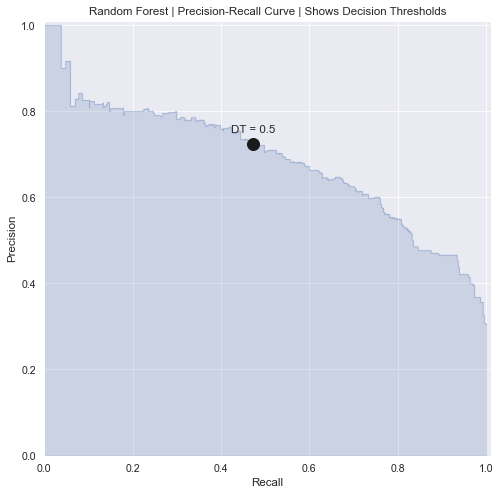

In [714]:
# generate Random Forest predict probabilities; store precision-recall curve values
y_hat_prob_test3 = gs_rf.predict_proba(X_test3)[:, 1]
p3, r3, thresholds3 = precision_recall_curve(y_test, y_hat_prob_test3)

# plot precision-recall curve for baseline decision threshold 0.5
plot_pr_curve(p3, r3, thresholds3, 'Random Forest', dt=[0.5])

**Random Forest Notes: Precision-Recall Curve**
- Default model uses 0.5 decision threshold show by circle on plot
- DT 0.5 lines up with recall = 0.46 and precision = 0.72
- Interested in finding DT for higher precision points as recommendation

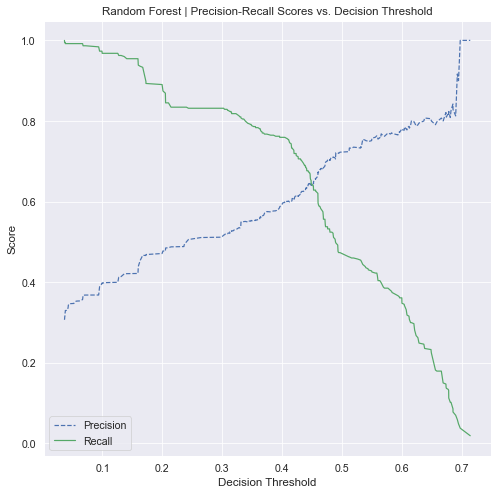

In [709]:
# plot precision and recall against decision threshold options
plot_pr_vs_dt(p3, r3, thresholds3, 'Random Forest')

**Random Forest Notes: Decision Threshold Options**
- Will recommend multi-tier solution based on several thresholds
- High cost solutions need higher precision to prevent overpredict churn
- Precision Breakpoints (Medium/Low incremental excluding higher levels):
    - **High**: DT=0.67-0.70 / 82% Precision / 15% Recall (55 true pos, 12 false pos)
    - **Medium**: DT=0.55-0.67 / 73% Precision / 27% Recall (103 true pos, 38 false pos)
    - **Low**: DT=0.45-0.55 / 50% Precision / 22% Recall (82 true pos, 83 false pos)
- Combining 3 tiers: Average Precision 64% covering 64% churn cases
- Not recommended: DT 0.1-0.45 / 36% Precision / 36% additional recall

In [731]:
# revised class predictions using decision threshold 0.90
y_hat_high_test3 = assign_class(y_hat_prob_test3, dt=0.67)
# confusion_matrix(y_test, y_pred_adj)
display_class_report(y_test, y_hat_high_test3)

               Retain Pred  Churn Pred
Retain Actual         1023          12
Churn Actual           319          55
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1035
           1       0.82      0.15      0.25       374

    accuracy                           0.77      1409
   macro avg       0.79      0.57      0.56      1409
weighted avg       0.78      0.77      0.70      1409



In [736]:
# revised class predictions using decision threshold 0.90
y_hat_med_test3 = assign_class(y_hat_prob_test3, dt=0.55)
# confusion_matrix(y_test, y_pred_adj)
display_class_report(y_test, y_hat_med_test3)

               Retain Pred  Churn Pred
Retain Actual          985          50
Churn Actual           216         158
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1035
           1       0.76      0.42      0.54       374

    accuracy                           0.81      1409
   macro avg       0.79      0.69      0.71      1409
weighted avg       0.80      0.81      0.79      1409



In [739]:
# revised class predictions using decision threshold 0.90
y_hat_low_test3 = assign_class(y_hat_prob_test3, dt=0.45)
# confusion_matrix(y_test, y_pred_adj)
display_class_report(y_test, y_hat_low_test3)

               Retain Pred  Churn Pred
Retain Actual          902         133
Churn Actual           134         240
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1035
           1       0.64      0.64      0.64       374

    accuracy                           0.81      1409
   macro avg       0.76      0.76      0.76      1409
weighted avg       0.81      0.81      0.81      1409



XGBoost Model AUC 0.699


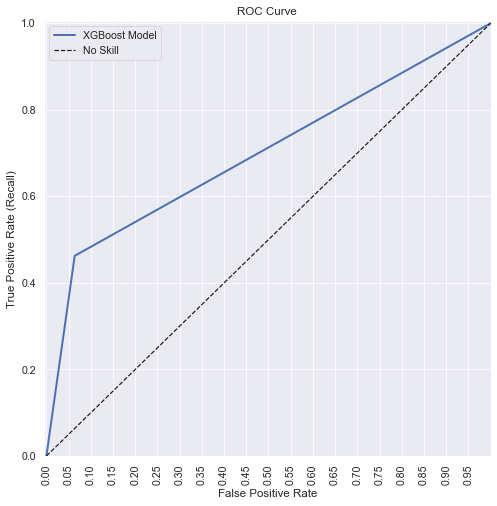

In [720]:
# plot the ROC Area Under Curve for Random Forest
fpr3, tpr3, auc_thresholds3 = roc_curve(y_test, y_hat_test3)
print(f'XGBoost Model AUC {round(auc(fpr3, tpr3), 3)}') # AUC of ROC
plot_roc_curve(fpr3, tpr3, 'XGBoost Model')

## m4 XGBoost

### Create Model 4

In [672]:
# define features to drop from X_train through iterations; not significant
m4_drops = ['customerid', 'count', 'country', 'city', 'state', 'zip_code', 
            'lat_long', 'churn_score', 'cltv', 'churn_reason', 'churn_rsn_grp_cust_svc',
            'churn_rsn_grp_moved', 'churn_rsn_grp_pricing',  'churn_rsn_grp_product', 
            'churn_rsn_grp_unknown', 'senior_citizen', 'gender_female', 'gender_male', 
            'online_security', 'online_backup',  'device_protection', 
            'multiple_lines', 'phone_service', 'tech_support', 'internet_svc_dsl', 
            'internet_svc_fiber', 'p1_phone_only', 'internet_svc_none', 'svc_add_ons', 
            'streaming_movies', 'streaming_tv', 'total_charges', 'charge_trend_index', 
            'monthly_charges', 'pmt_meth_mail_check', 'pmt_meth_cc_auto', 
            'pmt_meth_bank_trx_auto', 'pmt_meth_echeck', 'contract_mtm']

In [664]:
# apply drop columns against X_train and X_test for model 4
X_train4 = drop_features(X_train, m4_drops)
X_test4 = drop_features(X_test, m4_drops)

In [681]:
# document features included in XGBoost model
print(f'Model 4 XGBoost: {X_train4.shape[0]} rows | {X_train4.shape[1]} features')
print(f'Features included:\n{X_train4.columns}')

Model 4 XGBoost: 5634 rows | 16 features
Features included:
Index(['partner', 'dependents', 'tenure_months', 'paperless_billing',
       'contract_1yr', 'contract_2yr', 'p2_phone_multi', 'p3_dsl_only',
       'p4_dsl_plus', 'p5_dsl_bund_core', 'p6_dsl_bund_plus',
       'p7_fib_bund_core', 'p8_fib_bund_plus', 'streams', 'pmt_meth_auto',
       'charge_cust_index'],
      dtype='object')


In [682]:
# fit scaler to training data; transform both train and test dataframes
scaler = StandardScaler()
X_train4[X_train4.columns] = scaler.fit_transform(X_train4[X_train4.columns])
X_test4[X_test4.columns] = scaler.transform(X_test4[X_test4.columns])

In [683]:
# create XGBoost classifier object using logistic objective
model_xg = XGBClassifier(seed=SEED, objective='binary:logistic') 

### Run GridSearchCV

In [673]:
# Calculate positive class (churn=1) imbalance factor (2.8)
pos_weight = round((y_train.shape[0]-np.sum(y_train, axis = 0)) / np.sum(y_train, axis = 0), 1)

# Define the grid for XGBoost
param_grid_xg = {
    'learning_rate': [0.01, 0.1, 0.2], # step size for model iteration
    'reg_lambda': [1, 2], # L2 regularization term; higher=more conservative
    'scale_pos_weight': [pos_weight], # scale positive class to balance
    'max_depth': [4, 6, 8], # max number of trees deep
    'gamma': [1, 2, 4], # minimum loss reduction on partitions; higher=more conservative
    'subsample': [0.6, 0.8], # ratio of the training used to grow each tree
    'colsample_bytree': [0.7, 0.9], # ratio of columns when constructing each tree
    'n_estimators': [100, 250, 500], # number of trees to grow
}

**XGBoost Notes: Parameters**
- Parameter grid represents final selection of best parameter options for gridsearchCV. 
- Many other iterations were performed to rule in or out various parameters.

In [684]:
# create gridsearchCV object for XGBoost
gs_xg = instantiate_grid(model_xg, param_grid_xg)

In [448]:
# execute the XGBoost gridsearchCV on training data
gs_xg.fit(X_train4, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missin...
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 250, 500], 'reg_lambda': [1, 2],
                         'scale_pos_weight': [2.8], 'subsample': [0.6, 0.8]},
             refit='roc_auc',
             scoring={'a

### Model Performance

In [685]:
# print confusion matrix (train) for best model
best_model_xg = gs_xg.best_estimator_
print('XGBoost Confusion Matrix - Training Data')
display_confusion(best_model_xg, X_train4, y_train, labels=['Retain', 'Churn'])
print(f'Best Model Paramters: {gs_xg.best_index_} {gs_xg.best_estimator_.get_params}')

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

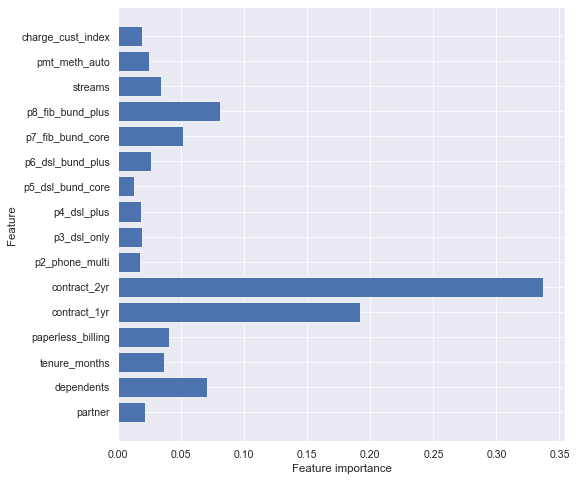

In [687]:
# plot XGBoost feature importance for best estimator
feature_importance_rf(best_model_xg, X_train4)

**XGBoost Notes: Feature Importance**
- Contract Type: Contracts 2yr/1yr (versus MTM) by far more influential
- Products: Product profiles containing Internet Fiber (p7/p8) are moderate
- Other Moderates: Has dependents, longer customer tenure and paperless billing
- Other Lows: Has partner, Streams, On automate payment method, customer charges relative to index

In [688]:
# display top model results
cv_results4 = pd.DataFrame.from_dict(gs_xg.cv_results_)
cv_results_metrics4 = show_grid_metrics(cv_results4, 'mean_test_roc_auc', top_n=5)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

### Predict Test

This section applies the best XGBoost estimator from above to unseen 20% Test holdout data. Below charts and plots evaluate predictive performance and insights.

In [555]:
# compare xgboost best estimator metrics for Train vs Test data sets
print('Train Performance - XGBoost Model\n---------------------------------')
y_hat_train4 = gs_xg.predict(X_train4)
scores_train_xg = score_pred('xg', 'train', y_train, y_hat_train4)

print('\nTest Performance - XGBoost Model\n--------------------------------')
y_hat_test4 = gs_xg.predict(X_test4)
scores_test_xg = score_pred('xg', 'test', y_test, y_hat_test4)

Train Performance - XGBoost Model
---------------------------------
Model xg Predictions: AUC 0.81 | Accuracy 0.78 | Recall 0.86 | Precision 0.56 | F1 0.68

Test Performance - XGBoost Model
--------------------------------
Model xg Predictions: AUC 0.79 | Accuracy 0.77 | Recall 0.83 | Precision 0.54 | F1 0.66


**XGBoost Notes: Train vs. Test**
- Each evaluation metric for Test is slightly lower than Train by 0.01 to 0.03.
- Given similarity, feel comfortable model is not overfitting train.
- Some prior iterations showed a 0.10 drop which was not acceptable.

XGBoost Confusion Matrix - Test Data - Best Model 470


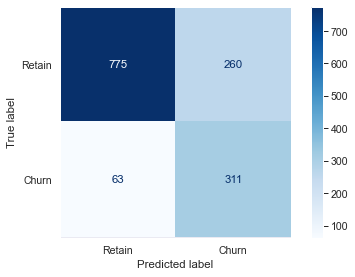

               Retain Pred  Churn Pred
Retain Actual          775         260
Churn Actual            63         311
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      1035
           1       0.54      0.83      0.66       374

    accuracy                           0.77      1409
   macro avg       0.73      0.79      0.74      1409
weighted avg       0.82      0.77      0.78      1409



In [595]:
# print confusion matrix for best xgboost model on test data
print(f'XGBoost Confusion Matrix - Test Data - Best Model {gs_xg.best_index_}')
display_confusion(best_model_xg, X_test4, y_test, labels=['Retain', 'Churn'])
display_class_report(y_test, y_hat_test4)

**XGBoost Notes: Confusion Matrix**
- Very pleased with 83% churn recall (we can predict 5/6 churn cases)
- Model precision of 54% not acceptable. Can't be wrong half the time.
- Explore precision-recall curve for options on decision threshold to increase precision

In [713]:
# generate XGBoost predict probabilities; store precision-recall curve values
y_hat_prob_test4 = gs_xg.predict_proba(X_test4)[:, 1]
p4, r4, thresholds4 = precision_recall_curve(y_test, y_hat_prob_test4)

# plot precision-recall curve for baseline decision threshold 0.5
plot_pr_curve(p4, r4, thresholds4, 'XGBoost', dt=[0.5])

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

**XGBoost Notes: Precision-Recall Curve**
- Default model uses 0.5 decision threshold show by circle on plot
- DT 0.5 lines up with recall = 0.83 and precision = 0.54
- Interested in finding DT for higher precision points as recommendation

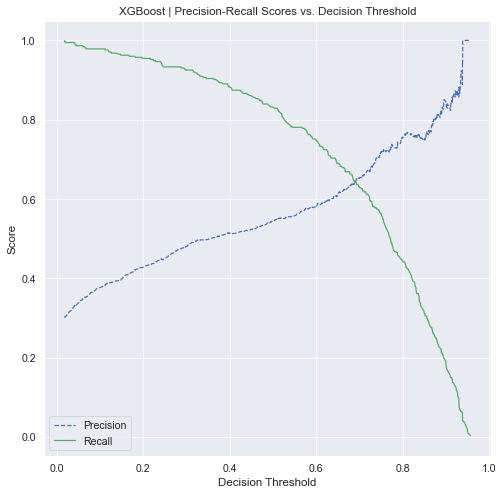

In [710]:
# plot precision and recall against decision threshold options
plot_pr_vs_dt(p4, r4, thresholds4, 'XGBoost')

**XGBoost Notes: Decision Threshold Options**
- Will recommend multi-tier solution based on several thresholds
- High cost solutions need higher precision to prevent overpredict churn
- Precision Breakpoints (Medium/Low incremental excluding higher levels):
    - **High**: DT=0.9-1.0 / 84% Precision / 18% Recall (67 true pos, 13 false pos)
    - **Medium**: DT=0.8-0.9 / 71% Precision / 26% Recall (98 true pos, 40 false pos)
    - **Low**: DT=0.7-0.8 / 49% Precision / 19% Recall (70 true pos, 72 false pos)
- Combining 3 tiers: Average Precision 65% covering 63% churn cases
- Not recommended: DT 0.5-0.7 / 36% Precision / 20% additional recall

In [653]:
# revised class predictions using decision threshold 0.90
y_hat_high_test4 = assign_class(y_hat_prob_test4, dt=0.90)
# confusion_matrix(y_test, y_pred_adj)
display_class_report(y_test, y_hat_high_test4)

               Retain Pred  Churn Pred
Retain Actual         1022          13
Churn Actual           307          67
              precision    recall  f1-score   support

           0       0.77      0.99      0.86      1035
           1       0.84      0.18      0.30       374

    accuracy                           0.77      1409
   macro avg       0.80      0.58      0.58      1409
weighted avg       0.79      0.77      0.71      1409



In [656]:
# revised class predictions using decision threshold 0.80
y_hat_med_test4 = assign_class(y_hat_prob_test4, dt=0.80)
# confusion_matrix(y_test, y_pred_adj)
display_class_report(y_test, y_hat_med_test4)

               Retain Pred  Churn Pred
Retain Actual          982          53
Churn Actual           209         165
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1035
           1       0.76      0.44      0.56       374

    accuracy                           0.81      1409
   macro avg       0.79      0.69      0.72      1409
weighted avg       0.81      0.81      0.80      1409



In [657]:
# revised class predictions using decision threshold 0.70
y_hat_med_test4 = assign_class(y_hat_prob_test4, dt=0.70)
# confusion_matrix(y_test, y_pred_adj)
display_class_report(y_test, y_hat_med_test4)

               Retain Pred  Churn Pred
Retain Actual          910         125
Churn Actual           139         235
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1035
           1       0.65      0.63      0.64       374

    accuracy                           0.81      1409
   macro avg       0.76      0.75      0.76      1409
weighted avg       0.81      0.81      0.81      1409



In [514]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

XGBoost Model AUC 0.79


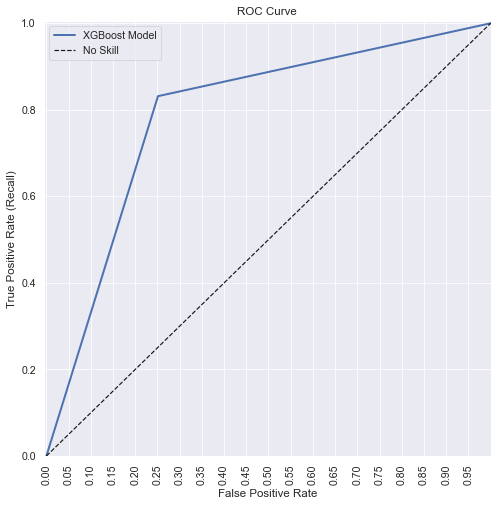

In [719]:
# plot the ROC Area Under Curve for XGBoost
fpr4, tpr4, auc_thresholds4 = roc_curve(y_test, y_hat_test4)
print(f'XGBoost Model AUC {round(auc(fpr4, tpr4), 3)}') # AUC of ROC
plot_roc_curve(fpr4, tpr4, 'XGBoost Model')

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();